# PCA mit Support Vector Machine

Eine SVM auf den Originaldaten zu trainieren dauert wegen des Lernalgorithmus der SVM lange.
Daher trainieren wir eine SVM nur auf der reduzierten Anzahl Features analog zur PCA kombiniert mit der Logistischen Regression.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import pickle

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np

import pandas as pd

from sklearn.svm import SVC

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    """
        Takes true and predicted labels (arrays) as input. Based on this, calculates and plots a confusion matrix.
    """
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

# Daten vorbereiten

In [3]:
# Daten laden und aufteilen in Features und Labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

## PCA mit SVM

Wir reduzieren die 3072 Features (`32 * 32 * 3` Pixel) zuerst mittels `PCA` auf 200 Features und trainieren anschliessend auf diesen 200 Features eine `SVM`.

In [5]:
%%time

pca_svm = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200)),
    ('clf', SVC(kernel='rbf'))
])

pca_svm.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

y_train_hat = pca_svm.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = pca_svm.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

Train:  0.68424
Val:    0.53288
CPU times: user 14min 4s, sys: 18.7 s, total: 14min 23s
Wall time: 13min 25s


Wir nutzen hier den `rbf` Kernel, sprich die Klassifikation ist nicht-linear.

Die SVM braucht (je nach Hardware) 10 Minuten um zu konvergieren. Dies liegt einerseits daran, dass die SVM eine valide Lösung finden muss (`max_iter` ist auf unendlich eingestellt).
Andererseits ist die SVM auch ein `Binär-Classifier` und verwendet das `One-Vs-One` Verfahren für die `Multi-Class-Classification` ([Quelle](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification)).
Beim `One-vs-One` Verfahren werden `n_classes * (n_classes - 1) / 2` Modelle trainiert, hier also `10 * (10 - 1) / 2 = 45`.
Das `SVC` Modell von sklearn trainiert also hinter den Kulissen 45 verschiedene Support Vector Machines.
Trainiert man eine `SVC` auf allen Pixel (ohne `PCA`), ist es bei uns **zeitlich** nicht konvergiert.

Ein nächster Schritt wäre hier sicherlich den `gamma` Parameter dieses Kernels noch mit Hyperparameter-Optimierung besser zu setzen, z.B. mittels `GridSearchCV` oder `RandomizedSearchCV`.
Mit der Trainingszeit von 10 Minuten der SVM kann dies je nach Suchraum länger dauern.

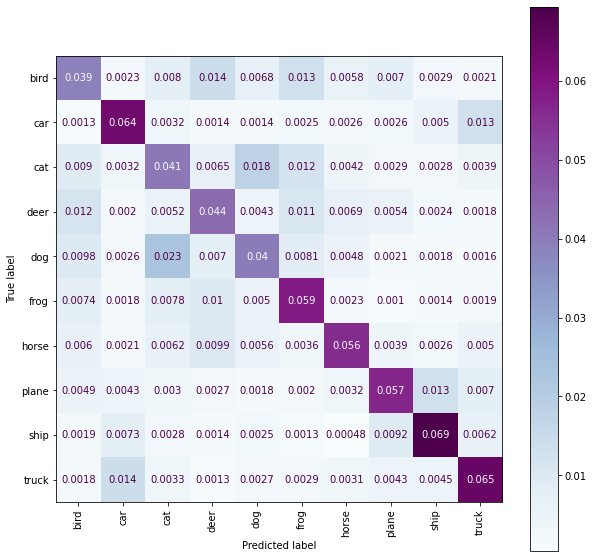

In [6]:
plot_confusion_matrix(y_true=y_val, y_pred=y_val_hat)

# Anwendung des Modells auf dem Test Set

Wenn wir mit der Leistung unseres Modells auf dem `Validation Set` zufrieden sind, können wir es auf das `Test Set` anwenden.

In [7]:
# Daten laden und aufteilen in Features und Labels
with open('../data/test.pkl', 'rb') as f:
    data_test = pickle.load(f)
X_test = data_test["images"]
y_test = data_test["labels"]

In [8]:
y_test_pred = pca_svm.predict(X_test.reshape(-1, 32 * 32 * 3))

Evaluieren wir unsere test-set predictions

In [9]:
accuracy_score(y_true=y_test, y_pred=y_test_pred)